#Import dependencies

In [1]:
#!if [ ! -f ArticleScraper.ipynb ]; then 
!curl https://raw.githubusercontent.com/Karocyt/covid-scraping/master/ArticleScraper.ipynb > ArticleScraper.ipynb
#; else echo "Already done"; fi
%run ArticleScraper.ipynb

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 21724  100 21724    0     0   230k      0 --:--:-- --:--:-- --:--:--  230k
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:10 http://arc

#Import private SSRN Credentials from Google Drive
###Credential file syntax:  
[comment]  
private_id=xxxx  
private_password=xxx

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Google drive authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# File params
local_save_dir = "/root/.ssrn"

# Name of your file on Google Drive
filename = "ssrn_credentials.txt"
save_path = "{0}/{1}".format(local_save_dir, filename)

# Choose/create a local (colab) directory to store the data.
local_download_path = os.path.expanduser(local_save_dir)
try:
  os.makedirs(local_download_path)
except: pass

# Replace id with id of your folder in GDrive (last field of url), remove curly braces altogether if in root
drive_list = drive.ListFile({'q': "'1xJJ-uaT89wIzJz009ARQdz_BDcuhPyYb' in parents and trashed=false"}).GetList()
f = [x for x in drive_list if x["title"] == filename][0]

print('title: %s, id: %s' % (f['title'], f['id']))
fname = os.path.join(local_download_path, f['title'])
print('downloading to {}'.format(fname))
f_ = drive.CreateFile({'id': f['id']})
f_.GetContentFile(fname)

with open(save_path) as creds:
    for i, line in enumerate(creds):
        if i == 1:
            private_id = line.replace("private_id=", "").replace("\n", "")
        if i == 2:
            private_password = line.replace("private_password=", "").replace("\n", "")

# IDs now in private_id and private_password variables

title: ssrn_credentials.txt, id: 1SUrcAKp-_1PjRZx6j9hMXgpVL0b4yZke
downloading to /root/.ssrn/ssrn_credentials.txt


#Dummy input for testing

In [0]:
example_dicts = [{'authors': 'C You, Y Deng, W Hu, J Sun, Q Lin, F Zhou… - Available at SSRN …, 2020 - papers.ssrn.com',
  'extra_link': 'https://www.medrxiv.org/content/medrxiv/early/2020/02/11/2020.02.08.20021253.full.pdf',
  'extra_link_text': '[PDF] medrxiv.org',
  'link': 'https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3539694',
  'preview': 'Background: The 2019 novel coronavirus (2019-nCoV) outbreak in Wuhan, China has\nattracted world-wide attention. As of February 11, 2020, a total of 44,730 cases of\npneumonia associated with the 2019-nCoV were confirmed by the National Health …',
  'title': 'Estimation of the Time-Varying Reproduction Number of COVID-19 Outbreak in China'},
 {'authors': 'J Gao, P Zheng, Y Jia, H Chen, Y Mao… - Available at SSRN …, 2020 - papers.ssrn.com',
  'extra_link': '',
  'extra_link_text': '',
  'link': 'https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3541120',
  'preview': 'Background: Huge citizens expos social media during a novel coronavirus disease (COVID-\n19) outbroke in Wuhan, China. We assess the prevalence of mental health problems and\nexamine their association with social media exposure. Methods: We conducted a cross …',
  'title': 'Mental Health Problems and Social Media Exposure During COVID-19 Outbreak'},
 {'authors': 'C GU, W Jiang, T Zhao, B Zheng - Available at SSRN 3551006, 2020 - papers.ssrn.com',
  'extra_link': '',
  'extra_link_text': '',
  'link': 'https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3551006',
  'preview': 'The statistics show that the mortality of COVID-19 is 20 times higher than seasonal flu and\nclose to that of Spanish flu, hence it is becoming an absolute priority for every country to take\nefficient measure to limit the transmission of COVID-19. In this short paper, we propose a …',
  'title': 'Mathematical Recommendations to Fight Against COVID-19'},
  ]

#SsrnSingleScraper Class 

Inherits from [ArticleScraper](https://colab.research.google.com/github/Karocyt/covid-scraping/blob/master/ArticleScraper.ipynb).  
Scrape one article from SSRN.
###Constructor
Takes a page dictionary (as given above) in it's constructor.
For now can optionnaly takes booleans (load_selenium, load_lxml, load_bs). Default is False and to consider everything True if nothing was specified.

###Parse method
Takes an optionnal retry_sec parameter (seconds), default is 60, set to None to don't retry.  
Return value: dictionary of relevant fields (see [ArticleScraper](https://colab.research.google.com/github/Karocyt/covid-scraping/blob/master/ArticleScraper.ipynb) for more info).

In [0]:
class SsrnSingleScraper(ArticleScraper):

  @property
  def title(self):
    return self.wd.title.split(' by ')[0]

  @property
  def authors(self):
    return self.wd.title.split(' by ')[1].split(" ::")[0]

  @property
  def doi(self):
    # SSRN seems to be recent pre-publications (not peer-reviewed yet) so no DOI in most cases?
    pattern = 'doi.org/'
    citation = self.wd.find_element(By.CLASS_NAME, 'suggested-citation').text
    ret = 'SSRN-ID' + self.page_dict['link'].split('=')[1]
    for word in citation.split(" "):
      if (word.startswith(pattern)):
        ret = word.split(pattern)[1]

    return ret

  @property
  def abstract(self):
    div = self.wd.find_element(By.CLASS_NAME, "abstract-text")
    text = div.find_element(By.TAG_NAME, "p").text
    return text # might need to remove sections titles and Funding section

  @property
  def date(self):
    text = self.wd.find_element(By.XPATH, '//*[@id="selectable"]').text
    # probably many different time formats, try/except might not be the best option
    try:
      date = datetime.strptime(text.split(")")[-2].split("(")[-1], '%m/%d/%Y')
    except:
      date = datetime.strptime(text.split(")")[-2].split("(")[-1], '%B %d, %Y')
    return date.strftime(self.date_format)

  @property
  def body(self):
    """
    self.wd.find_element(By.XPATH, '//*[@id="maincontent"]/div[1]/div[1]/div/div[2]/a').click()
    time.sleep(0.2)
    content = ""
    print(os.listdir())
    for file in os.listdir():
      if file.endswith(".pdf"):
        with open(file, 'rb') as f:
          pdf_reader = PyPDF2.PdfFileReader(f)
          for page in pdf_reader.pages:
            content += page.extractText()
        os.remove(file)
        break

    return content # raw full text (with header, abstract, footers, references and so on)
    """
    return None

  @property
  def source(self):
    return "SSRN"

  @property
  def source_impact_factor(self):
    return None

  @property
  def search_keyword(self):
    return None

  @property
  def categories(self):
    return None

  @property
  def licence(self):
    return None

  @property
  def citations(self):
    return None

  @property
  def organization(self):
    # Using organization of lead author
    authors = self.wd.find_element(By.CLASS_NAME, 'authors-full-width')
    return authors.find_element(By.TAG_NAME, 'p').text

  @property
  def keywords(self):
    keywords = self.wd.find_element_by_xpath("//*[contains(text(), 'Keywords:')]/..").text.split(': ')[1]
    return ",".join(keywords.split(';'))

  @property
  def references(self):
    # format in references is not consistent, sometimes missing field,
    # other times data in the wrong field, hence dirty try/except...
    self.wd.find_element_by_xpath('//*[@id="references-widget"]/button').click()
    time.sleep(0.2)
    li_list = self.wd.find_elements_by_xpath('//*[@id="references-widget"]/ol/li')
    refs = []
    for elem in li_list:
      ref = {}
      try:
        ref['title'] = elem.find_element(By.CLASS_NAME, 'reference-title').text
      except:
        ref['title'] = ""
      
      try:
        ref['authors'] = elem.find_element(By.CLASS_NAME, 'author-list').text
      except:
        ref['authors'] = ""
      
      try:
        link = elem.find_element(By.TAG_NAME,  'a')
        ref['link'] = link.get_attribute('href')
      except:
        ref['link'] = ""
      refs.append(ref)
    
    return refs

  @property
  def link(self):
    return self.page_dict['link']

  @property
  def extralinks(self):
    return self.page_dict['extra_link']
  

#SsrnScraper class and test
##SsrnScraper 
###Constructor
Takes id and password as parameters.  
Logs in to avoid random redirects to login screen. 
###Parse method
Takes an array of page dictionnaries (see Dummy input section) and an optionnal retry_sec parameter (seconds, default is 60, set to None to don't retry) that will be forwarded to SsrnSingleScraper instances.
Return value: yields the next dictionary of relevant fields as return by SsrnSingleScraper class for each page in the given array.


In [0]:
class SsrnScraper():
  login_screen = 'https://hq.ssrn.com/login/pubsigninjoin.cfm'

  def __init__(self, connect_id, connect_password):
    wd = ArticleScraper.wd
    wd.get(self.login_screen)
    # Needs to login to avoid random "please connect" screen
    try:
      wd.find_element(By.NAME, 'input-email').send_keys(connect_id)
      wd.find_element(By.NAME, 'input-pass').send_keys(connect_password)
      wd.find_element(By.ID, 'signinBtn').click()
    except Exception as e:
      print("WARNING: error while trying to connect via %s" % (self.login_screen), e)
      wd.save_screenshot("temp.png")
      display(Image(filename="temp.png"))
      # Remember_me might be working
      pass

  def parse(self, pages_dict, retry_sec = None):
    for d in pages_dict:
      yield SsrnSingleScraper(d).parse(retry_sec = 2)  

scraper = SsrnScraper(private_id, private_password)


ERROR: while handling https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3539694 list index out of range


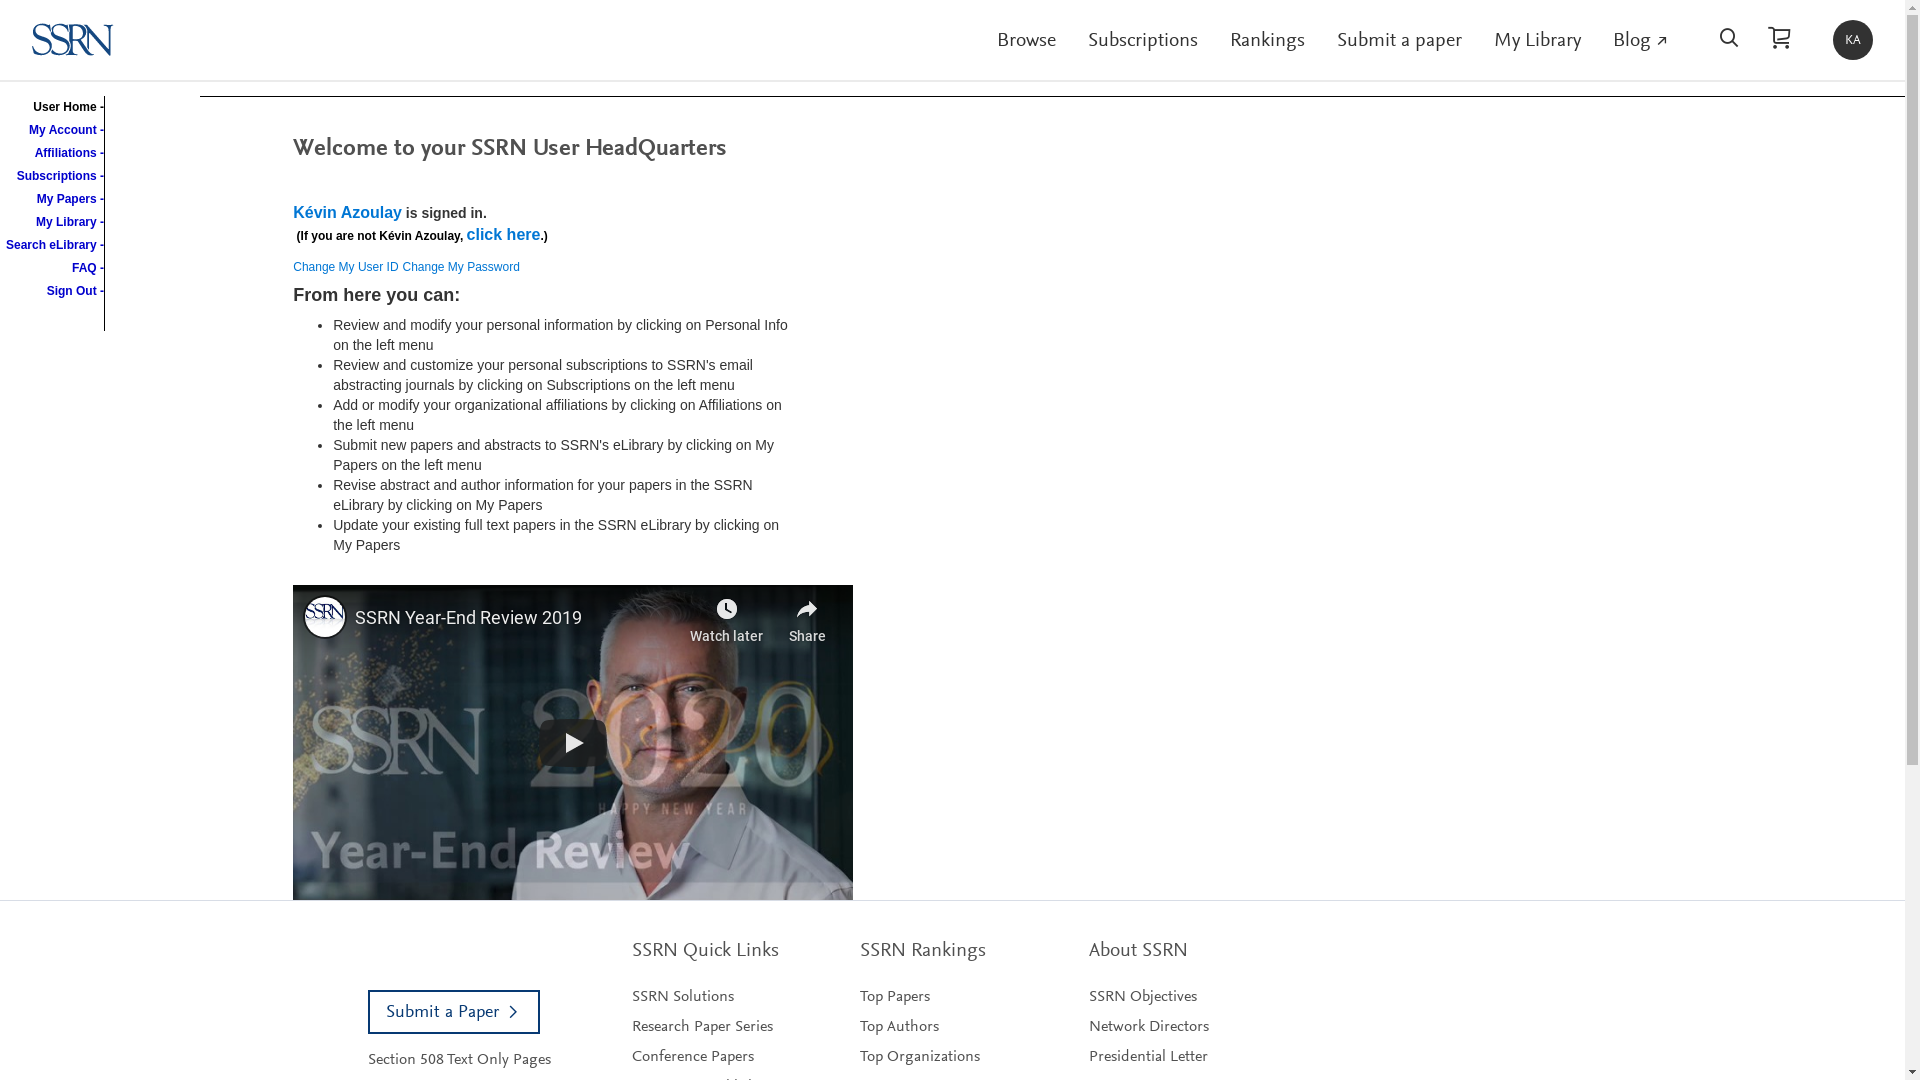

Current URL: https://hq.ssrn.com/UserHome.cfm?redirectFrom=true
Retrying in  2 seconds...


Traceback (most recent call last):
  File "<ipython-input-1-31d787c6f7eb>", line 100, in parse
    'Authors': self.authors,
  File "<ipython-input-4-a9982ee1d2ed>", line 9, in authors
    return self.wd.title.split(' by ')[1].split(" ::")[0]
IndexError: list index out of range


Retrying now
Title: Estimation of the Time-Varying Reproduction Number of COVID-19 Outbreak in China
Authors: Chong You, Yuhao Deng, Wenjie Hu, Jiarui Sun, Qiushi Lin, Feng Zhou, Cheng Heng Pang, Yuan Zhang, Zhengchao Chen, Xiao-Hua Zhou
DOI: SSRN-ID3539694
Abstract: Background: The 2019 novel coronavirus (2019-nCoV) outbreak in Wuhan, China has attracted world-wide attention. As of February 11, 2020, a total of 44,730 cases of pneumonia associated with the 2019-nCoV were confirmed by the National Health Commission (NHC) of China.

Methods: Three approaches, namely Poisson likelihood-based method (ML), exponential growth rate-based method (EGR) and stochastic Susceptible-Infected-Removed dynamic model-based method (SIR), were implemented to estimate the basic and controlled reproduction numbers.

Results: A total of 71 chains of transmission together with dates of symptoms onset and 67 dates of infections were identified among 5,405 confirmed cases outside Hubei as reported by February

In [6]:
for d in scraper.parse(example_dicts):
  for k in d:
    print(k, d[k], sep=": ")
  print()

In [7]:
print(" test test".split(' '))

['', 'test', 'test']
